# Plot registration and Jacobian determinants

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

from otimage import imagerep, io
from otimage.utils import plot_maxproj_units, plot_img_units
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

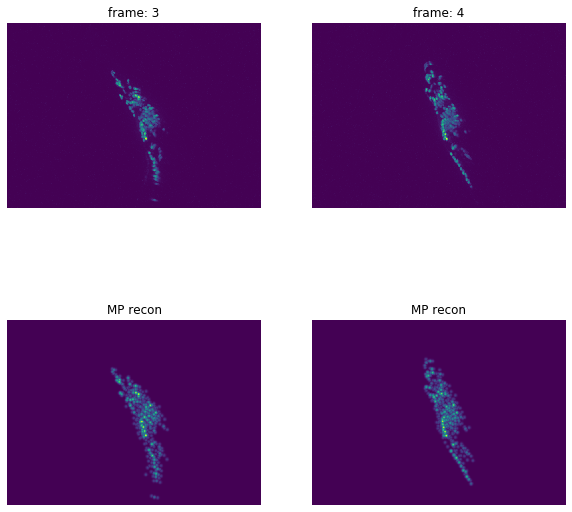

In [3]:
# Frame index
t1 = 3
t2 = 4

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    units = reader.units
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.h5'
with io.MPReader(mp_path) as reader:
    mp_1 = reader.get_frame(t1)
    mp_2 = reader.get_frame(t2)

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_mp_image(mp_1, units)
rec_2 = imagerep.reconstruct_mp_image(mp_2, units)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj_units(img_1, units)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj_units(img_2, units)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj_units(rec_1, units)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj_units(rec_2, units)
plt.title('MP recon')
plt.axis('off');

## Compute registrations for images

In [4]:
degree = 2
n_iter = 50

model, debug = gw_registration(mp_1, mp_2, degree=degree, n_iter=n_iter)

print('beta (est):')
print(model.beta)

beta (est):
[[ 2.17609183e+02 -9.50721475e-01 -1.21790158e+00 -5.81228780e-01
   4.95713909e-03  2.92059454e-03  4.06327312e-04  3.58925326e-03
   6.08971155e-03  1.89214851e-03]
 [ 6.62769965e+02 -6.04987333e+00 -2.11658931e+00 -1.57936258e+00
   1.39383416e-02  1.38274344e-02  3.15471396e-03  3.95611762e-03
   8.71864698e-03  5.80558613e-03]
 [ 3.27808409e+01 -2.49823847e-01 -2.07151947e-02 -3.40037415e-01
   3.41895687e-04  4.15181199e-04  5.68266241e-03 -5.03520426e-04
   3.67161662e-03  8.68716270e-04]]


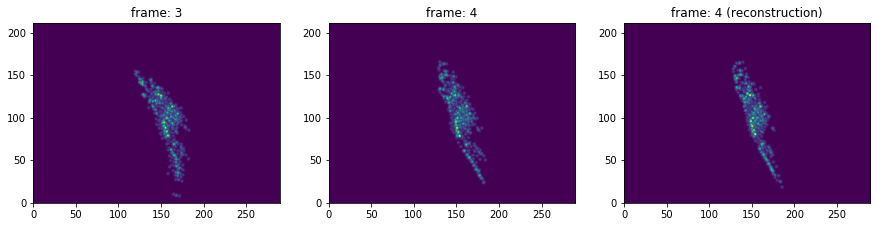

In [5]:
# Transform MP points for first image using mapping
pf_pts = model.predict(mp_1.pts)

# Reconstruct image from transformed points
mp_pf = imagerep.ImageMP(pf_pts, mp_1.wts, mp_1.cov, mp_1.img_limits)
rec_pf = imagerep.reconstruct_mp_image(mp_pf, units)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj_units(rec_1, units)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj_units(rec_2, units)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj_units(rec_pf, units)
plt.title(f'frame: {t2} (reconstruction)');

## Plot transformation and Jacobians

### Plot vector field and Jacobians

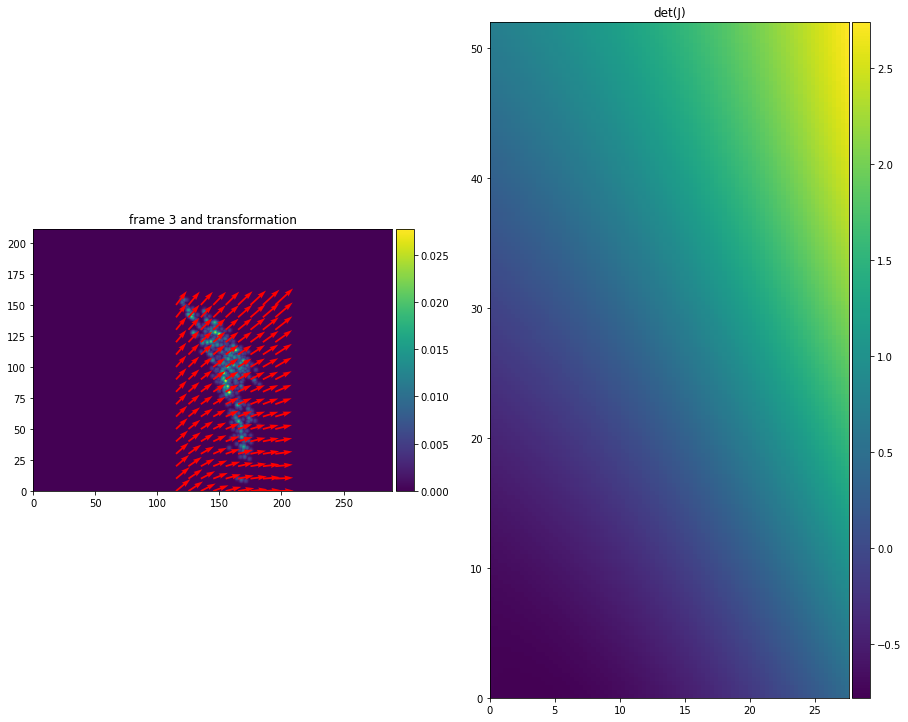

In [19]:
# Window surrounding worm
xlim = (115, 200)
ylim = (0, 160)
zval = 10

# Grid for vector field plotting
x_vf, y_vf = np.mgrid[xlim[0]:xlim[1]:10, ylim[0]:ylim[1]:10]
vf_shape = x_vf.shape
z_vf = np.ones(vf_shape) * zval
vf_grid = np.concatenate(
    [x_vf.reshape(-1, 1), y_vf.reshape(-1, 1), z_vf.reshape(-1, 1)], 
    axis=1
)

# Vector field
v_grid = model.predict(vf_grid)
vx = v_grid[:, 0].reshape(vf_shape)
vy = v_grid[:, 1].reshape(vf_shape)
vz = v_grid[:, 2].reshape(vf_shape)

# Grid for Jacobian plotting
x_jac, y_jac = np.mgrid[xlim[0]:xlim[1], ylim[0]:ylim[1]]
jac_shape = x_jac.shape
z_jac = np.ones(jac_shape) * zval
jac_grid = np.concatenate(
    [x_jac.reshape(-1, 1), y_jac.reshape(-1, 1), z_jac.reshape(-1, 1)], 
    axis=1
)

# Compute determinants of Jacobians on grid
jac_dets = model.det_jac(jac_grid)
#jac_dets_plt = np.zeros((rec_1.shape[0], rec_1.shape[1]))
#jac_dets_plt[xlim[0]:xlim[1], ylim[0]:ylim[1]] = jac_dets.reshape(jac_shape)
jac_dets_plt = jac_dets.reshape(jac_shape)


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15, 15))

# Plot vector field
im1 = plot_maxproj_units(rec_1, units, ax=ax1)
ax1.quiver(x_vf, y_vf, vx, vy, color='red')
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title(f'frame {t1} and transformation')

#im2 = ax2.imshow(jac_dets_plt.T, origin='lower')
im2 = plot_img_units(jac_dets_plt, units, ax=ax2)
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('det(J)');

### Plot coordinates of transformation

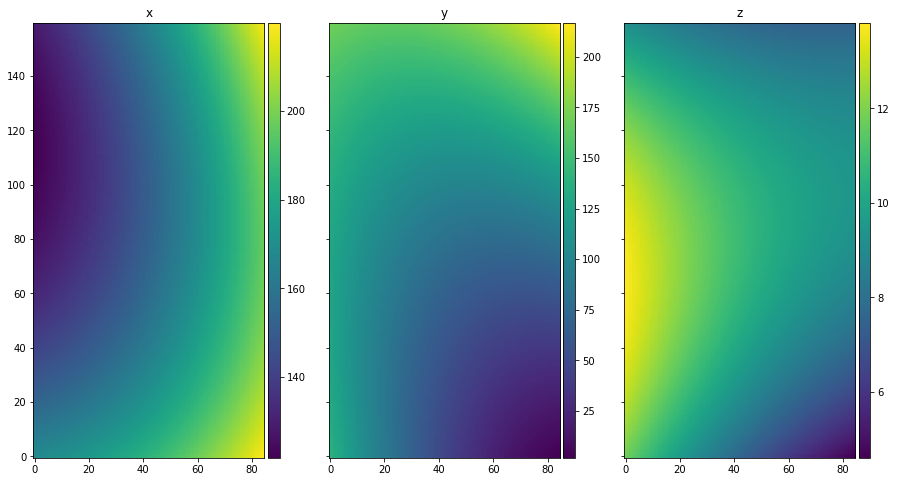

In [20]:
# Grid for vector field plotting
x_vf, y_vf = np.mgrid[xlim[0]:xlim[1], ylim[0]:ylim[1]]
vf_shape = x_vf.shape
z_vf = np.ones(vf_shape) * zval
vf_grid = np.concatenate(
    [x_vf.reshape(-1, 1), y_vf.reshape(-1, 1), z_vf.reshape(-1, 1)], 
    axis=1
)

# Vector field
v_grid = model.predict(vf_grid)
vx = v_grid[:, 0].reshape(vf_shape)
vy = v_grid[:, 1].reshape(vf_shape)
vz = v_grid[:, 2].reshape(vf_shape)

# X-values to plot
#vx_plt = np.zeros((rec_1.shape[0], rec_1.shape[1]))
#vx_plt[xlim[0]:xlim[1], ylim[0]:ylim[1]] = vx

# Y-values to plot
#vy_plt = np.zeros((rec_1.shape[0], rec_1.shape[1]))
#vy_plt[xlim[0]:xlim[1], ylim[0]:ylim[1]] = vy

# Z-values to plot
#vz_plt = np.zeros((rec_1.shape[0], rec_1.shape[1]))
#vz_plt[xlim[0]:xlim[1], ylim[0]:ylim[1]] = vz

# Plot X, Y, and Z values as heatmaps
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 15))

im1 = ax1.imshow(vx.T, origin='lower')
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('x');

im2 = ax2.imshow(vy.T, origin='lower')
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('y');

im3 = ax3.imshow(vz.T, origin='lower')
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax3.set_title('z');